<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Notebook Stylisé</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            margin: 0;
        }
        .notebook {
            width: 80%;
            max-width: 800px;
            background: white;
            padding: 20px;
            border-radius: 10px;
            box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2);
            border: 2px solid #ccc;
            position: relative;
        }
        .notebook::before {
            content: "";
            position: absolute;
            top: 10px;
            left: 10px;
            right: 10px;
            bottom: 10px;
            border: 2px dashed #999;
        }
        h1 {
            text-align: center;
            color: #333;
        }
        h3, h2 {
            text-align: center;
            color: #333;
        }
        .content {
            padding: 15px;
            line-height: 1.6;
            color: #000;
        }
        .center {
            display: block;
            margin-left: auto;
            margin-right: auto;
            /* width: 50%; */
        }
    </style>
</head>
<body>

<div class="notebook center">
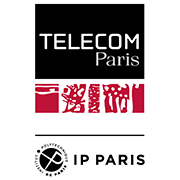
    <h1>IA705 - Projet d'apprentissage par renforcement</h1>
        <h2>OpenTheChests Challenge.</h2>
            <h3>Mathieu Delarue & Laury Magne & Robin Guiavarch & François-Xavier Morel</h3>
            <div class="content">7/5/2025
            </div>
</div>

</body>
</html>



# Initialisation du notebook

In [1]:
!pip install gymnasium pybullet stable-baselines3
!pip install tensorboard
!pip install imageio imageio-ffmpeg
!pip install openthechests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [3]:
import gym
import gymnasium
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_
import pybullet as p
import pybullet_data
import warnings
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.nn.functional as F

from openthechests.src.OpenTheChestsGym import OpenTheChestsGym

from stable_baselines3 import SAC
from stable_baselines3.her.her_replay_buffer import HerReplayBuffer
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
import os

from IPython.display import HTML
from IPython.display import Video
import time
import imageio
from IPython.display import Video

from register_envs import all_types, all_attributes, register_custom_envs

In [4]:
# sauvegarde du model
version="1-2"
save_model_path="modelSAC3BoiteGripperV"+version


# Qu'est-ce que le projet?

Notre projet consiste à concevoir un système multi-agent où un Agent 1 instruit un bras robotique (Agent 2) pour qu’il réalise une tâche complexe en plusieurs étapes : saisir une boîte, la soulever, puis la déposer dans une zone cible. L’Agent 1 doit analyser une séquence d’événements et produire une instruction binaire à destination de l’Agent 2, qui doit ensuite exécuter correctement l'action dans un environnement physique simulé.

**L'Agent 1 prend ses décisions sur la base d'une interaction avec l'environnement OpenTheChests, basé sur Gym** tandis que **l'Agent 2 opère dans un environnement de simulation physique basé Gymnasium**

A noter que les entrainements des agents a été réalisé dans des Notebooks séparés, livrés avec ce notebook.

#### 🤖 Agent 1 : décision

L’Agent 1 est un agent Q-learning appris via l'algorithme double DQN avec une politique ε-greedy. Ces instructions représentent un ordre donné à l'Agent 2 : quelle boîte aller manipuler.(réseau de neurones QNetwork). Il prend comme entrée un vecteur représentant l’historique des événements récents. Pour l'environnement V0, la longueur de l'historique est fixée à 1 contre 4 pour la V1. A partir d'une séquence d'état, l'agent sélectionne parmi 8 instructions codées sur 3 bits pour représenter tous les ordres possible : ne rien faire ou au contraire, sélectionner un ou plusieurs objectifs.

D'autres approches que DQN ont été essayées, elles sont détaillées dans le notebook d'entraînement de l'Agent 1 mais n'ont pas été reprises ici au vue de leurs contre-performences.

#### 🦾 Agent 2 : exécution physique

L’Agent 2 est un agent basé sur Stable-Baselines3 (par ex. PPO, SAC, etc.), entraîné séparément à réaliser la tâche de manipulation avec succès, quelle que soit la position de la boîte. Lorsque l’Agent 1 sélectionne un ou plusieurs objectifs, l’Agent 2 se voit assigner chaque cible et tente de l’accomplir. Le succès ou l’échec est vérifié via un indicateur booléen.

#### 🧠 Représentation séquentielle de l’état

Pour prendre en compte la dynamique temporelle, nous avons conçu une fenêtre glissante (sliding window) d’événements encodés. Chaque observation est convertie en un vecteur de 33 dimensions via une fonction dédiée encapsulant :
- Le type d’événement
- Les couleurs de fond et de symbole
- Les timestamps de début et de fin

Une séquence de seq_len événements est stockée dans un tenseur state_tensor, mis à jour dynamiquement à chaque pas. Ce tenseur est ensuite aplati (flatten) pour obtenir une entrée de taille fixe pour le Q-network.

#### 🔁 Boucle de validation

Ce pipeline met en œuvre un système multi-agent où :

- l’un raisonne sur un historique abstrait (événements symboliques),
- l’autre agit dans le monde physique simulé (actions continues).

Dans la fonction showcase_agents_skills :
- Chaque épisode commence par un reset de l’environnement.
- L’Agent 1 observe une séquence d’événements, puis choisit une ou plusieurs boîtes à manipuler.
- L’Agent 2 essaie d’exécuter les instructions.

Le système affiche les résultats :
- Succès complet si toutes les tâches ont été accomplies
- Échec si Agent 1 ou Agent 2 se trompe

#### 🧪 Conclusion

**En conclusion, nous sommes parvenus à faire travailler deux agents avec un taux de succès important dans les environnements V0 et V1 pour la tâche de qui consiste à venir toucher l'objectif.**

Les résulats pour l'environnement V2 ainsi que pour des tâches plus complexes que le simple touché de boîte sont beaucoup plus irréguliers. Tous les détails concerant ces difficultés sont fournis dans les notebooks d'entraînement des agents en question.

# Environnements

## Définition de l'environnement du bras robotique (Agent 2)

In [14]:
class pandaReachFixedEnv(gymnasium.Env):
    def __init__(self, max_steps=50, training=True, success_phase=2):
        """
          pandaReachFixedEnv
          ------------------

          Environnement Gymnasium personnalisé pour l'apprentissage par renforcement d’un bras robotisé Panda
          utilisant PyBullet.

          Objectif :
          ----------
          Le bras doit saisir une boîte posée sur une table, la lever à une certaine hauteur, puis la relâcher
          dans une cible définie. Le comportement est contrôlé par une machine à états (5 phases) guidant la progression :
              0 - Approche
              1 - Alignement
              2 - Saisie
              3 - Levée
              4 - Relâche

          Fonctionnalités :
          -----------------
          - Mode entraînement (`training=True`) avec remise à zéro des boîtes à chaque reset.
          - Mode continu pour l’inférence avec boîtes persistantes.
          - Détection du grasp via les contacts sur les deux doigts.
          - Retour d’un indicateur `success` dans l’`info` du `step` pour analyse des succès.
          - Commande du bras via inverse kinematics, avec configuration des limites, damping, etc.
          - Calcul du reward spécifique à chaque phase.
          - Rendu RGB via une caméra virtuelle PyBullet pour enregistrement vidéo.
        """
        super().__init__()
        self.success_phase=success_phase
        self.max_steps = max_steps
        self.step_counter = 0
        self.render_mode = "rgb_array"
        self.box_height = 0.04
        # 0 = approche, 1 = alignement, 2 = saisie, 3 = levée, 4 = lachée
        self.phase = 0
        self.grip_open = 0.04      # m  (4 cm ⇢ ~8 cm d’écartement)
        self.grip_closed = 0.00
        self.grip_open_large = 0.08  # pour lâcher la boite à la fin

        # vélocité du gripper par phase
        self.pk1 = 0.12        # phase 0
        self.pk2 = 0.06
        self.kd  = 0.5
        self.max_vel_phase0 = 0.5
        self.max_vel_phasefine  = 0.2

        # Gère le passage en continue ou avec un reset de l'environement
        self.training = training

        self.required_stable_steps = 3

        if p.isConnected():
            p.disconnect()
        p.connect(p.DIRECT)

        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.81)

        self.plane_id = p.loadURDF("plane.urdf")
        self.panda_id = p.loadURDF("franka_panda/panda.urdf", useFixedBase=True, flags=p.URDF_USE_SELF_COLLISION)

        # On garde en commentaire, nécessaire pour trouver les ids des joints
        # for j in range(p.getNumJoints(self.panda_id)):
        #     print(j, p.getJointInfo(self.panda_id, j)[1].decode())

        self.arm_joints = range(7)
        self.end_effector_index = 11
        self.grip_joint = 9

        self.goal_ids = []
        self.goals = [
            np.array([0.6, -0.2, 0.02], dtype=np.float32),
            np.array([0.6,  0.0, 0.02], dtype=np.float32),
            np.array([0.6,  0.2, 0.02], dtype=np.float32)
        ]
        self.target_id = 1
        self.goal = self.goals[self.target_id]

        self.action_space = spaces.Box(
            low=np.array([-0.05, -0.10, -0.05, 0]),
            high=np.array([0.10,0.10,0.10,1]),
            dtype=np.float32
        )

        self.observation_space = spaces.Box(low=-2, high=2, shape=(9,), dtype=np.float32)

        # init des boites
        half = self.box_height / 2.0

        colors = [
            [1, 0, 0, 1],  # Rouge
            [0, 1, 0, 1],  # Vert
            [0, 0, 1, 1],  # Bleu
        ]

        for idx, (x, y, _) in enumerate(self.goals):
            z = half

            vis_box_id = p.createVisualShape(
                p.GEOM_BOX,
                halfExtents=[half, half, half],
                rgbaColor=colors[idx]
            )
            col_box_id = p.createCollisionShape(
                p.GEOM_BOX,
                halfExtents=[half, half, half]
            )
            goal_id = p.createMultiBody(
                baseMass=0.05,
                baseCollisionShapeIndex=col_box_id,
                baseVisualShapeIndex=vis_box_id,
                basePosition=[x, y, z]
            )
            p.changeDynamics(goal_id, -1, lateralFriction=1.0, restitution=0.0)
            self.goal_ids.append(goal_id)

        # init du bras
        self.home = [0, -0.6, 0, -1.8, 0, 2.0, 0.8]
        for j, q in enumerate(self.home):
            p.resetJointState(self.panda_id, j, q)

        p.resetJointState(self.panda_id, self.grip_joint, self.grip_open)
        p.setJointMotorControl2(
            self.panda_id, self.grip_joint,
            p.POSITION_CONTROL,
            targetPosition=self.grip_open,
            force=50
        )



    def reset(self, *, seed=None):
        self.step_counter = 0
        self.phase = 0
        self.stable_counter = 0

        # pendant l'entrainement, on remet les boites et le bras en init
        if self.training:
            # On remet le bras dans sa position initiale
            for j, q in enumerate(self.home):
                p.resetJointState(self.panda_id, j, q)

            p.resetJointState(self.panda_id, self.grip_joint, self.grip_open)
            p.setJointMotorControl2(
                self.panda_id, self.grip_joint,
                p.POSITION_CONTROL,
                targetPosition=self.grip_open,
                force=50
            )

            # on supprime et recrée les boites
            for goal_id in self.goal_ids:
                p.removeBody(goal_id)
            self.goal_ids.clear()

            half = self.box_height / 2.0

            colors = [
                [1, 0, 0, 1],  # Rouge
                [0, 1, 0, 1],  # Vert
                [0, 0, 1, 1],  # Bleu
            ]
            for idx, (x, y, _) in enumerate(self.goals):
                z = half

                vis_box_id = p.createVisualShape(
                    p.GEOM_BOX,
                    halfExtents=[half, half, half],
                    rgbaColor=colors[idx]
                )
                col_box_id = p.createCollisionShape(
                    p.GEOM_BOX,
                    halfExtents=[half, half, half]
                )
                goal_id = p.createMultiBody(
                    baseMass=0.05,
                    baseCollisionShapeIndex=col_box_id,
                    baseVisualShapeIndex=vis_box_id,
                    basePosition=[x, y, z]
                )
                p.changeDynamics(goal_id, -1, lateralFriction=1.0, restitution=0.0)
                self.goal_ids.append(goal_id)
        else:
            self.goal = np.array(p.getBasePositionAndOrientation(self.goal_ids[self.target_id])[0], dtype=np.float32)

        for _ in range(10):
            p.stepSimulation()

        return self._get_obs(), {}

    def step(self, action):
        self.step_counter += 1
        if self.step_counter == 1:
            print(f"💥Nouvel objectif - cible {self.target_id} (position: {self.goal})")

        move_action = action[:3]
        grip_action = action[3]
        current_pos = self._get_ee_position()
        target_pos = current_pos + move_action
        target_pos = np.clip(target_pos, [0.3, -0.3, 0.02], [0.8, 0.3, 1.0])

        # orientation pointe-vers-le-bas (π rad autour X)
        target_orn = p.getQuaternionFromEuler([-np.pi, 0, 0])

        joint_angles = p.calculateInverseKinematics(
            self.panda_id,
            self.end_effector_index,
            target_pos,
            targetOrientation=target_orn,
            # limite les angles possible
            lowerLimits=[-2.8973, -1.7628, -2.8973, -3.0718, -2.8973, -0.0175, -2.8973],
            upperLimits=[ 2.8973,  1.7628,  2.8973, -0.0698,  2.8973,  3.7525,  2.8973],
            jointRanges=[5.8, 3.5, 5.8, 3.0, 5.8, 3.8, 5.8],
            restPoses=[0, -0.6, 0, -1.8, 0, 2.0, 0.8],
            # limite l'usage du gripper
            jointDamping=[0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.01]
        )

        # pour limité la vélocité / réactivité du bras
        kp = self.pk1 if self.phase == 0 else self.pk2
        current_max_vel = self.max_vel_phase0 if self.phase == 0 else self.max_vel_phasefine

        # Mouvement du bras
        for j in self.arm_joints:
            p.setJointMotorControl2(
                self.panda_id, j,
                p.POSITION_CONTROL,
                targetPosition=joint_angles[j],
                positionGain=kp,
                velocityGain=self.kd,
                maxVelocity=current_max_vel,
                force=300
            )

        # On laisse le gripper ouvert pendant les phases d'approche
        if self.phase < 1:
            p.setJointMotorControl2(
                self.panda_id, self.grip_joint,
                p.POSITION_CONTROL,
                targetPosition=self.grip_open,
                force=80
            )

        # Contrôle du gripper, uniquement à partir de la phase 2, sinon il reste ouvert
        if self.phase == 2:
            binary = int(grip_action > 0.5)        # 0 ou 1
            d = self.grip_closed if binary else self.grip_open

            p.setJointMotorControl2(
                self.panda_id, self.grip_joint,
                p.POSITION_CONTROL,
                targetPosition=d,
                force=150
            )
        # On le bloque en phase 3
        elif self.phase == 3:
            p.setJointMotorControl2(
                self.panda_id, self.grip_joint,
                p.POSITION_CONTROL,
                targetPosition=self.grip_closed,
                force=150
            )
        # On lache la boite en phase 4
        if self.phase == 4:
            p.setJointMotorControl2(
                    self.panda_id, self.grip_joint,
                    p.POSITION_CONTROL,
                    targetPosition=self.grip_open_large,
                    force=100
            )

        for _ in range(10):
            p.stepSimulation()

        terminated = False
        truncated  = False

        obs = self._get_obs()
        ee_pos = obs[:3]
        goal_pos = obs[3:6]
        diff = obs[6:9]
        dist = np.linalg.norm(diff)

        reward = 0
        success = False

        dx = abs(ee_pos[0] - goal_pos[0])
        dy = abs(ee_pos[1] - goal_pos[1])
        lateral_error = np.sqrt(dx**2 + dy**2)
        dz = ee_pos[2] - goal_pos[2]

        # Phase 0 : approche de la boite
        if self.phase == 0:
            reward = -(dist + lateral_error)

            if dist < 0.06 and dx < 0.01 and dy < 0.01:
                self.stable_counter += 1
                reward += 1  # ← petit bonus à chaque step stable
                if self.stable_counter >= self.required_stable_steps:
                    # print("phase 1")
                    self.phase = 1
                    self.stable_counter = 0
                    reward += 20
            else:
                self.stable_counter = 0

        # Phase 1 : positionnement doigts
        elif self.phase == 1:
            if dz < 0.18 and dx < 0.01 and dy < 0.01:
                # print("phase 2")
                self.phase = 2
                reward += 20
                if self.success_phase == 1:
                    success = True
                    terminated = True
            else:
                reward = -(dist + lateral_error)

        # Phase 2 : Saisie
        elif self.phase == 2:
            if self._check_grasp():
                self.stable_counter += 1
                reward += 1
                if self.stable_counter >= self.required_stable_steps:
                    # print("phase 3")
                    self.phase = 3
                    reward += 20
                    self.stable_counter = 0
                    if self.success_phase == 2:
                        success = True
                        terminated = True
            else:
                self.stable_counter = 0
                reward = -(dist + lateral_error)

        # Phase 3 : Levée
        elif self.phase == 3:
            hold = self._check_grasp()
            if hold:
                # if self.training:
                #     print("goal_pos[2]" + str(goal_pos[2]))
                # reward += 40 * (goal_pos[2] - 0.02)
                reward += 40 * (goal_pos[2] - 0.02) + 200 * (goal_pos[2] - 0.02) ** 2
            else:
                reward -= 5
                # print("raté, hauteur = " + str(goal_pos[2]))
                terminated = True

            if hold and goal_pos[2] > 0.12:
                reward += 20
                # print("phase 4")
                self.phase = 4
                if self.success_phase == 3:
                        success = True
                        terminated = True

        # Phase 4 : lacher la boite
        if self.phase == 4:
            if not self._check_grasp() and goal_pos[2] < 0.08:
                reward += 20
                # print("Done")
                self.phase = 0
                self.stable_counter = 0
                terminated = True
                success = True
            else:
                reward = -10 * goal_pos[2]


        truncated = self.step_counter >= self.max_steps

        if (terminated or truncated) and self.training:
            self.switch_target()

        return obs, reward, terminated, truncated, {"success": success}

    # pour l'environnement de production (continue)
    # on ne fait plus de reset mais on choisit une autre boite
    def switch_target(self, new_target_id=None):
        if new_target_id is not None:
            self.target_id = new_target_id
        elif self.training:
            self.target_id = np.random.randint(len(self.goal_ids))

        self.phase = 0
        self.stable_counter = 0

    # position du gripper (milieu entre les bouts des pinces /!\ le bout et 1.x cm avant le bout)
    def _get_ee_position(self):
        pos_l = p.getLinkState(self.panda_id, 9)[0]
        pos_r = p.getLinkState(self.panda_id, 10)[0]
        pos = np.mean([pos_l, pos_r], axis=0)
        return np.array(pos, dtype=np.float32)

    # position du gripper, position de la boite (centre), diff des 2 vecteurs
    def _get_obs(self):
        ee_pos = self._get_ee_position()
        goal_pos, _ = p.getBasePositionAndOrientation(self.goal_ids[self.target_id])
        goal_pos = np.array(goal_pos, dtype=np.float32)
        diff = goal_pos - ee_pos
        return np.concatenate([ee_pos, goal_pos, diff]).astype(np.float32)

    def _check_grasp(self):
        bid = self.goal_ids[self.target_id]
        l_ok = [c for c in p.getContactPoints(bodyA=self.panda_id, linkIndexA=9, bodyB=bid) if c[9] > 1.0]
        r_ok = [c for c in p.getContactPoints(bodyA=self.panda_id, linkIndexA=10, bodyB=bid) if c[9] > 1.0]
        return bool(l_ok and r_ok)

    # Fonction d'enregistrement de vidéo périodiquement
    def render(self):
        if self.render_mode == "rgb_array":
            width, height, rgb, _, _ = p.getCameraImage(
                width=640,
                height=480,
                viewMatrix=p.computeViewMatrix(
                    cameraEyePosition=[1.4, -1.1, 0.9],
                    cameraTargetPosition=[0.6, 0.0, 0.1],
                    cameraUpVector=[0, 0, 1]
                ),
                projectionMatrix=p.computeProjectionMatrixFOV(
                    fov=50, aspect=640/480, nearVal=0.1, farVal=2.0
                )
            )
            return np.reshape(rgb, (height, width, 4))[:, :, :3]
        return None

        pass

    def close(self):
        if p.isConnected():
            p.disconnect()


## Définition de l'environnement OpenTheChests et de l'agent décisionnel (Agent 1)

In [6]:

class QNetwork(nn.Module):
    """
    A feedforward neural network for Q-learning.
    - Input: State vector (e.g., 16D if using a sliding window of 4 events).
    - Output: Q-values for each possible action (8 in this example).

    Args:
        state_size (int): Dimensionality of the input state.
        action_size (int): Number of possible actions (8).
    """
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        """
        Forward pass through the Q-network.

        Args:
            x (torch.Tensor): Input state tensor of shape (batch_size, state_size).

        Returns:
            torch.Tensor: Q-values of shape (batch_size, action_size).
        """
        return self.fc(x)

def event_from_obs_gym(obs, types, attributes):
    """
    Extracts event information from the environment observation.
    Converts indices into human-readable symbols an
    d colors.
    """
    return {
        "symbol": types[obs["e_type"]],  # Convert event index to actual event type
        "bg_color": attributes["bg"][obs["bg"]],  # Convert bg index to color
        "symbol_color": attributes["fg"][obs["fg"]],  # Convert fg index to color
        "start_time": obs["start"][0],
        "end_time": obs["end"][0]
    }

def select_action(model, state, eps=0.1, device="cpu"):
    """
    Epsilon-greedy action selection.

    Args:
        model (QNetwork): The Q-network.
        state (np.ndarray): Encoded input state (e.g., shape (16,)).
        eps (float): Exploration probability.
        device (str): Torch device ("cpu" or "cuda").

    Returns:
        int: Chosen action index in [0..7].
    """
    if np.random.rand() < eps:
        return np.random.randint(0, 8)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = model(state_tensor)
        return torch.argmax(q_values, dim=1).item()

def encode_symbol_bg_fg(event: dict, all_types, all_attributes) -> np.ndarray:
    """
    Encode an event into a one-hot vector + times:
    [symbol_oh (15D), bg_oh (8D), fg_oh (8D), start_time, end_time].

    Returns a 33D vector.
    """
    symbol_vec = np.zeros(len(all_types), dtype=np.float32)
    bg_vec = np.zeros(len(all_attributes["bg"]), dtype=np.float32)
    fg_vec = np.zeros(len(all_attributes["fg"]), dtype=np.float32)

    # 1) Encode symbol
    symbol = event.get("symbol", None)
    if symbol in all_types:
        symbol_idx = all_types.index(symbol)
        symbol_vec[symbol_idx] = 1.0

    # 2) Encode bg color
    bg_color = event.get("bg_color", None)
    if bg_color in all_attributes["bg"]:
        bg_idx = all_attributes["bg"].index(bg_color)
        bg_vec[bg_idx] = 1.0

    # 3) Encode fg color
    fg_color = event.get("symbol_color", None)
    if fg_color in all_attributes["fg"]:
        fg_idx = all_attributes["fg"].index(fg_color)
        fg_vec[fg_idx] = 1.0

    # 4) Encode times
    # si l'event n'a pas de champ time => 0.0 par défaut
    start_time = float(event.get("start_time", 0.0))
    end_time   = float(event.get("end_time", 0.0))

    # Concatène => 15 + 8 + 8 + 2 = 33D
    return np.concatenate([
        symbol_vec,
        bg_vec,
        fg_vec,
        np.array([start_time, end_time], dtype=np.float32)
    ], axis=0)

def convert_index_to_action(index: int) -> np.ndarray:
    """
    Convert an integer index (0 to 7) into a 3-bit binary action vector.

    Example:
        4 → [1, 0, 0]
    """
    assert 0 <= index < 8, "Index must be between 0 and 7 (inclusive)"
    binary_action = np.array([int(digit) for digit in bin(index).removeprefix("0b").zfill(3)])
    # print(f"[convert_index_to_action] Index {index} -> Binary {binary_action}")
    return binary_action

register_custom_envs()

# Définition de la boucle de validation

La fonction ci-dessous apaire le bras robotique Agent 2 avec le  cerveau Agent 1

In [7]:
def showcase_agents_skills(episodes=10, env_name="OpenTheChests-v0", seq_len=1):

  openChests_env = gym.make(env_name)

  for ep in range(episodes):
      chobs = openChests_env.reset()
      event_dict = event_from_obs_gym(chobs, all_types, all_attributes)
      state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
      done = False
      agent2_success = []
      reward_agent_1 = 0
      steps = 0
      print(f"Episode {ep+1}:")
      state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
      do_nothing = np.zeros(3)

      while not done:
          # 1) Create a state tensor equal to the sequence length and get Q-values
          while len(state_tensor) != seq_len:
            chobs, _, done, _ = openChests_env.step(do_nothing)
            event_dict = event_from_obs_gym(chobs, all_types, all_attributes)
            next_state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
            state_tensor = torch.vstack([state_tensor, torch.tensor(next_state, dtype=torch.float32, device=device)])
          with torch.no_grad():
              q_values = q_net(state_tensor.flatten())
              action_index = torch.argmax(q_values, dim=-1).item()

          # 2) Convert action index to 3-bit action
          action = convert_index_to_action(action_index)

          # 3) Step in OpenTheChests environment
          obs, reward, done, _ = openChests_env.step(action)
          steps += 1

          # 4) Sliding the temporal window : add the next state, remove last
          event_dict = event_from_obs_gym(obs, all_types, all_attributes)
          state = encode_symbol_bg_fg(event_dict, all_types, all_attributes)
          state_tensor = torch.vstack([state_tensor, torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)])
          state_tensor = state_tensor[1:]

          # 5) Pass order to agent 2 and score
          reward_agent_1 += reward
          target_ids = np.argwhere(action==1).flatten()
          if len(target_ids)==0:
              pass
          else:
              for target_id in target_ids:
                  # Agent 2
                  env.switch_target(new_target_id=target_id)
                  obs, _ = env.reset()
                  result = False
                  for _ in range(env.max_steps):
                      action, _ = model.predict(obs, deterministic=True)
                      obs, reward, terminated, truncated, success = env.step(action)
                      if success["success"]:
                          result = True
                      if terminated or truncated:
                          pass
                  agent2_success.append(result)

      if reward_agent_1 == 3 and all(agent2_success):
          print("✅✨ Succès total!")
      if reward_agent_1 != 3 and steps >= 3:
          print(f"⚠️❌ Agent 1 s'est trompé quelque part : reward cumulée = {reward_agent_1}")
      else:
          print("✅✈️ Agent 1 a donné les bonnes instructions au bras mécanique !")
      if not all(agent2_success):
          failed_steps = [i for i, success in enumerate(agent2_success) if not success]
          print(f"⚠️❌ Agent 2 a échoué au(x) épisode(s) : {failed_steps}")
      else:
          print("✅🫡 Agent 2 a rempli toutes les missions assignées par Agent 1!")
      print('--------------------------------------------------------------------')

  return None

# Exécution de la boucle de validation dans l'environnement OpenTheChests-V0\

In [38]:
# Préparation de l'Agent 1 pour l'environnement v0
state_size, action_size = 33, 8
device = "cpu"
q_net = QNetwork(state_size, action_size)
params = torch.load('weights/qnet_env_v0_gamma_0.5.pth', map_location=torch.device('cpu'))
q_net.load_state_dict(params)
q_net.eval()

QNetwork(
  (fc): Sequential(
    (0): Linear(in_features=33, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
)

In [39]:
# Préparation de l'Agent 2 pour l'environnement Gymnasium
# on dit qu'on reset et qu'il y a succès si la phase 2 est réussie
warnings.filterwarnings("ignore")
withreset = True
if p.isConnected():
    p.disconnect()
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
env = pandaReachFixedEnv(max_steps=150, training=withreset, success_phase=2)
model = SAC.load(save_model_path + ".zip")

In [40]:
showcase_agents_skills(episodes=10, env_name='OpenTheChests-v0', seq_len=1)

Episode 1:
💥Nouvel objectif - cible 0 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 2 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 1 (position: [0.6  0.   0.02])
✅✨ Succès total!
✅✈️ Agent 1 a donné les bonnes instructions au bras mécanique !
✅🫡 Agent 2 a rempli toutes les missions assignées par Agent 1!
--------------------------------------------------------------------
Episode 2:
💥Nouvel objectif - cible 0 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 2 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 1 (position: [0.6  0.   0.02])
✅✨ Succès total!
✅✈️ Agent 1 a donné les bonnes instructions au bras mécanique !
✅🫡 Agent 2 a rempli toutes les missions assignées par Agent 1!
--------------------------------------------------------------------
Episode 3:
💥Nouvel objectif - cible 2 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 0 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 1 (position: [0.6  0.   0.02])
✅✨ Succès total!
✅✈️ Agent 1 a donné 

# Exécution de la boucle de validation dans l'environnement OpenTheChests-V1

In [19]:
# Préparation de l'Agent 1 pour l'environnement v1
state_size, action_size = 33*4, 8
device = "cpu"
q_net = QNetwork(state_size, action_size)
params = torch.load('weights/qnet_env_v1_gamma_0.5.pth', map_location=torch.device('cpu'))
q_net.load_state_dict(params)
q_net.eval()

QNetwork(
  (fc): Sequential(
    (0): Linear(in_features=132, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
)

In [21]:
# Préparation de l'Agent 2 pour l'environnement Gymnasium
warnings.filterwarnings("ignore")
withreset = True
if p.isConnected():
    p.disconnect()
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
env = pandaReachFixedEnv(max_steps=150, training=withreset)
model = SAC.load(save_model_path + ".zip")

In [22]:
showcase_agents_skills(episodes=10, env_name='OpenTheChests-v1', seq_len=4)

Episode 1:
💥Nouvel objectif - cible 0 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 2 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 1 (position: [0.6  0.   0.02])
✅✨ Succès total!
✅✈️ Agent 1 a donné les bonnes instructions au bras mécanique !
✅🫡 Agent 2 a rempli toutes les missions assignées par Agent 1!
--------------------------------------------------------------------
Episode 2:
💥Nouvel objectif - cible 0 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 1 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 2 (position: [0.6  0.   0.02])
✅✨ Succès total!
✅✈️ Agent 1 a donné les bonnes instructions au bras mécanique !
✅🫡 Agent 2 a rempli toutes les missions assignées par Agent 1!
--------------------------------------------------------------------
Episode 3:
💥Nouvel objectif - cible 0 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 1 (position: [0.6  0.   0.02])
💥Nouvel objectif - cible 2 (position: [0.6  0.   0.02])
✅✨ Succès total!
✅✈️ Agent 1 a donné 